In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run2.framed",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": -1,
    "num_examples_per_domain_per_label_target": -1,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 608.5737, train_label_loss: 2.8232, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 10478.4395, train_label_loss: 2.6887, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 10618.6622, train_label_loss: 2.6085, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 10670.3566, train_label_loss: 2.5075, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 10613.3842, train_label_loss: 2.3305, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 10617.3542, train_label_loss: 2.1909, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 10570.1219, train_label_loss: 2.0089, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 10557.2512, train_label_loss: 1.7954, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 10685.9365, train_label_loss: 1.8543, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 10636.8544, train_label_loss: 1.5110, 


epoch: 1, source_val_acc_label: 0.5526, source_val_label_loss: 1.5012, target_val_acc_label: 0.5526, target_val_label_loss: 1.5012, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 48.9902, train_label_loss: 1.4000, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 10623.0515, train_label_loss: 1.4392, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 10673.6144, train_label_loss: 1.3398, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 10598.9161, train_label_loss: 1.3207, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 10636.1198, train_label_loss: 1.1353, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 10569.7548, train_label_loss: 1.1747, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 10603.7534, train_label_loss: 0.9638, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 10586.6999, train_label_loss: 0.9117, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 10668.9116, train_label_loss: 0.8757, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 10531.0119, train_label_loss: 0.9401, 


epoch: 2, source_val_acc_label: 0.8214, source_val_label_loss: 0.7312, target_val_acc_label: 0.8214, target_val_label_loss: 0.7312, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 56.4108, train_label_loss: 0.6620, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 10625.9119, train_label_loss: 0.6873, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 10618.6067, train_label_loss: 0.5378, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 10654.7526, train_label_loss: 0.5843, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 10664.9484, train_label_loss: 0.6385, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 10628.4253, train_label_loss: 0.5095, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 10606.0532, train_label_loss: 0.6784, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 10590.2396, train_label_loss: 0.5748, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 10613.4966, train_label_loss: 0.3375, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 10662.6578, train_label_loss: 0.3713, 


epoch: 3, source_val_acc_label: 0.8959, source_val_label_loss: 0.4234, target_val_acc_label: 0.8959, target_val_label_loss: 0.4234, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 56.0535, train_label_loss: 0.4422, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 10505.8319, train_label_loss: 0.3962, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 10555.1371, train_label_loss: 0.5385, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 10663.5624, train_label_loss: 0.5160, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 10697.4267, train_label_loss: 0.4116, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 10564.8757, train_label_loss: 0.3972, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 10670.8974, train_label_loss: 0.5987, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 10566.1426, train_label_loss: 0.3704, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 10597.9821, train_label_loss: 0.3355, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 10734.7376, train_label_loss: 0.4161, 


epoch: 4, source_val_acc_label: 0.9312, source_val_label_loss: 0.2816, target_val_acc_label: 0.9312, target_val_label_loss: 0.2816, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 57.0155, train_label_loss: 0.3070, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 10613.6524, train_label_loss: 0.2629, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 10660.6494, train_label_loss: 0.2499, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 10668.6300, train_label_loss: 0.1948, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 10672.0383, train_label_loss: 0.2899, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 10573.3114, train_label_loss: 0.2688, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 10661.0773, train_label_loss: 0.2659, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 10717.6060, train_label_loss: 0.2063, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 10586.4494, train_label_loss: 0.1648, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 10664.4067, train_label_loss: 0.2653, 


epoch: 5, source_val_acc_label: 0.9377, source_val_label_loss: 0.2246, target_val_acc_label: 0.9377, target_val_label_loss: 0.2246, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 56.0009, train_label_loss: 0.2082, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 10670.8902, train_label_loss: 0.2334, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 10678.9495, train_label_loss: 0.1718, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 10647.7626, train_label_loss: 0.1930, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 10696.6442, train_label_loss: 0.1675, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 10688.2112, train_label_loss: 0.3244, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 10667.2809, train_label_loss: 0.2626, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 10656.8177, train_label_loss: 0.2499, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 10640.4066, train_label_loss: 0.2346, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 10708.4305, train_label_loss: 0.1810, 


epoch: 6, source_val_acc_label: 0.9427, source_val_label_loss: 0.2013, target_val_acc_label: 0.9427, target_val_label_loss: 0.2013, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 55.8060, train_label_loss: 0.1507, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 10643.2568, train_label_loss: 0.2318, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 10684.7045, train_label_loss: 0.1743, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 10585.9067, train_label_loss: 0.2462, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 10709.3414, train_label_loss: 0.2070, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 10621.4517, train_label_loss: 0.1864, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 10640.9233, train_label_loss: 0.3154, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 10658.0387, train_label_loss: 0.1624, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 10672.1550, train_label_loss: 0.1560, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 10723.3171, train_label_loss: 0.1919, 


epoch: 7, source_val_acc_label: 0.9453, source_val_label_loss: 0.1804, target_val_acc_label: 0.9453, target_val_label_loss: 0.1804, 


New best
epoch: 8, [batch: 1 / 1400], examples_per_second: 56.2653, train_label_loss: 0.1631, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 10544.9494, train_label_loss: 0.2992, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11009.3137, train_label_loss: 0.2245, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11679.2079, train_label_loss: 0.2128, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11702.6622, train_label_loss: 0.1605, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11702.3998, train_label_loss: 0.1293, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11728.6647, train_label_loss: 0.3622, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11704.6759, train_label_loss: 0.1272, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11708.3754, train_label_loss: 0.1147, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11687.0276, train_label_loss: 0.1271, 


epoch: 8, source_val_acc_label: 0.9492, source_val_label_loss: 0.1601, target_val_acc_label: 0.9492, target_val_label_loss: 0.1601, 


New best
epoch: 9, [batch: 1 / 1400], examples_per_second: 63.3125, train_label_loss: 0.1166, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11636.8024, train_label_loss: 0.1164, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 11671.2645, train_label_loss: 0.1900, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11679.3131, train_label_loss: 0.1528, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11646.4196, train_label_loss: 0.1634, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11671.0742, train_label_loss: 0.1382, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11637.4071, train_label_loss: 0.1047, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11663.6594, train_label_loss: 0.1276, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11741.2571, train_label_loss: 0.2025, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11679.9810, train_label_loss: 0.1414, 


epoch: 9, source_val_acc_label: 0.9522, source_val_label_loss: 0.1752, target_val_acc_label: 0.9522, target_val_label_loss: 0.1752, 


New best
epoch: 10, [batch: 1 / 1400], examples_per_second: 63.9822, train_label_loss: 0.1102, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11723.8826, train_label_loss: 0.1175, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11717.0854, train_label_loss: 0.1114, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11681.4187, train_label_loss: 0.1044, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11641.1453, train_label_loss: 0.1428, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 11749.4780, train_label_loss: 0.1476, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11765.3465, train_label_loss: 0.0982, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11732.7548, train_label_loss: 0.1031, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 11756.1803, train_label_loss: 0.1162, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 11762.3288, train_label_loss: 0.1452, 


epoch: 10, source_val_acc_label: 0.9547, source_val_label_loss: 0.1401, target_val_acc_label: 0.9547, target_val_label_loss: 0.1401, 


New best
epoch: 11, [batch: 1 / 1400], examples_per_second: 63.6074, train_label_loss: 0.1403, 


epoch: 11, [batch: 140 / 1400], examples_per_second: 11541.9128, train_label_loss: 0.1277, 


epoch: 11, [batch: 280 / 1400], examples_per_second: 11728.4231, train_label_loss: 0.1111, 


epoch: 11, [batch: 420 / 1400], examples_per_second: 11693.5279, train_label_loss: 0.1275, 


epoch: 11, [batch: 560 / 1400], examples_per_second: 11733.1321, train_label_loss: 0.1047, 


epoch: 11, [batch: 700 / 1400], examples_per_second: 11721.4014, train_label_loss: 0.1537, 


epoch: 11, [batch: 840 / 1400], examples_per_second: 11678.8740, train_label_loss: 0.1699, 


epoch: 11, [batch: 980 / 1400], examples_per_second: 11723.2223, train_label_loss: 0.1070, 


epoch: 11, [batch: 1120 / 1400], examples_per_second: 11752.3513, train_label_loss: 0.1149, 


epoch: 11, [batch: 1260 / 1400], examples_per_second: 11721.9571, train_label_loss: 0.1274, 


epoch: 11, source_val_acc_label: 0.9569, source_val_label_loss: 0.1349, target_val_acc_label: 0.9569, target_val_label_loss: 0.1349, 


New best
epoch: 12, [batch: 1 / 1400], examples_per_second: 64.4931, train_label_loss: 0.1272, 


epoch: 12, [batch: 140 / 1400], examples_per_second: 12412.2960, train_label_loss: 0.1267, 


epoch: 12, [batch: 280 / 1400], examples_per_second: 11755.1341, train_label_loss: 0.3203, 


epoch: 12, [batch: 420 / 1400], examples_per_second: 11672.5405, train_label_loss: 0.0969, 


epoch: 12, [batch: 560 / 1400], examples_per_second: 11679.7777, train_label_loss: 0.0826, 


epoch: 12, [batch: 700 / 1400], examples_per_second: 11665.5928, train_label_loss: 0.1473, 


epoch: 12, [batch: 840 / 1400], examples_per_second: 11675.8243, train_label_loss: 0.1300, 


epoch: 12, [batch: 980 / 1400], examples_per_second: 11642.6293, train_label_loss: 0.1111, 


epoch: 12, [batch: 1120 / 1400], examples_per_second: 11645.8981, train_label_loss: 0.0601, 


epoch: 12, [batch: 1260 / 1400], examples_per_second: 11679.6870, train_label_loss: 0.1221, 


epoch: 12, source_val_acc_label: 0.9549, source_val_label_loss: 0.1656, target_val_acc_label: 0.9549, target_val_label_loss: 0.1656, 


epoch: 13, [batch: 1 / 1400], examples_per_second: 64.2215, train_label_loss: 0.1197, 


epoch: 13, [batch: 140 / 1400], examples_per_second: 11550.4306, train_label_loss: 0.1041, 


epoch: 13, [batch: 280 / 1400], examples_per_second: 11708.6800, train_label_loss: 0.0776, 


epoch: 13, [batch: 420 / 1400], examples_per_second: 11732.8738, train_label_loss: 0.0704, 


epoch: 13, [batch: 560 / 1400], examples_per_second: 11721.2040, train_label_loss: 0.1481, 


epoch: 13, [batch: 700 / 1400], examples_per_second: 11713.5922, train_label_loss: 0.0980, 


epoch: 13, [batch: 840 / 1400], examples_per_second: 11709.3403, train_label_loss: 0.0850, 


epoch: 13, [batch: 980 / 1400], examples_per_second: 11739.2326, train_label_loss: 0.1460, 


epoch: 13, [batch: 1120 / 1400], examples_per_second: 11683.0002, train_label_loss: 0.0790, 


epoch: 13, [batch: 1260 / 1400], examples_per_second: 11744.7394, train_label_loss: 0.1033, 


epoch: 13, source_val_acc_label: 0.9524, source_val_label_loss: 0.1654, target_val_acc_label: 0.9524, target_val_label_loss: 0.1654, 


epoch: 14, [batch: 1 / 1400], examples_per_second: 64.7413, train_label_loss: 0.1132, 


epoch: 14, [batch: 140 / 1400], examples_per_second: 11625.3599, train_label_loss: 0.1069, 


epoch: 14, [batch: 280 / 1400], examples_per_second: 11705.0788, train_label_loss: 0.0507, 


epoch: 14, [batch: 420 / 1400], examples_per_second: 11676.9235, train_label_loss: 0.1207, 


epoch: 14, [batch: 560 / 1400], examples_per_second: 11647.7408, train_label_loss: 0.0523, 


epoch: 14, [batch: 700 / 1400], examples_per_second: 11745.7250, train_label_loss: 0.0984, 


epoch: 14, [batch: 840 / 1400], examples_per_second: 12471.7795, train_label_loss: 0.0929, 


epoch: 14, [batch: 980 / 1400], examples_per_second: 12994.2683, train_label_loss: 0.0704, 


epoch: 14, [batch: 1120 / 1400], examples_per_second: 13075.5645, train_label_loss: 0.0748, 


epoch: 14, [batch: 1260 / 1400], examples_per_second: 13004.9232, train_label_loss: 0.0938, 


epoch: 14, source_val_acc_label: 0.9572, source_val_label_loss: 0.1236, target_val_acc_label: 0.9572, target_val_label_loss: 0.1236, 


New best
epoch: 15, [batch: 1 / 1400], examples_per_second: 72.1066, train_label_loss: 0.1312, 


epoch: 15, [batch: 140 / 1400], examples_per_second: 12866.0231, train_label_loss: 0.0937, 


epoch: 15, [batch: 280 / 1400], examples_per_second: 13042.1937, train_label_loss: 0.0405, 


epoch: 15, [batch: 420 / 1400], examples_per_second: 13004.4642, train_label_loss: 0.1376, 


epoch: 15, [batch: 560 / 1400], examples_per_second: 12992.3883, train_label_loss: 0.1398, 


epoch: 15, [batch: 700 / 1400], examples_per_second: 12977.5333, train_label_loss: 0.1387, 


epoch: 15, [batch: 840 / 1400], examples_per_second: 12787.7994, train_label_loss: 0.0666, 


epoch: 15, [batch: 980 / 1400], examples_per_second: 13016.7632, train_label_loss: 0.0665, 


epoch: 15, [batch: 1120 / 1400], examples_per_second: 12817.4593, train_label_loss: 0.0851, 


epoch: 15, [batch: 1260 / 1400], examples_per_second: 12981.9580, train_label_loss: 0.1332, 


epoch: 15, source_val_acc_label: 0.9647, source_val_label_loss: 0.1072, target_val_acc_label: 0.9647, target_val_label_loss: 0.1072, 


New best
epoch: 16, [batch: 1 / 1400], examples_per_second: 72.1932, train_label_loss: 0.0601, 


epoch: 16, [batch: 140 / 1400], examples_per_second: 12916.1363, train_label_loss: 0.1545, 


epoch: 16, [batch: 280 / 1400], examples_per_second: 13023.2791, train_label_loss: 0.1433, 


epoch: 16, [batch: 420 / 1400], examples_per_second: 13027.0802, train_label_loss: 0.0947, 


epoch: 16, [batch: 560 / 1400], examples_per_second: 13034.9513, train_label_loss: 0.0444, 


epoch: 16, [batch: 700 / 1400], examples_per_second: 13064.2418, train_label_loss: 0.1253, 


epoch: 16, [batch: 840 / 1400], examples_per_second: 13056.7798, train_label_loss: 0.0868, 


epoch: 16, [batch: 980 / 1400], examples_per_second: 13030.2691, train_label_loss: 0.1197, 


epoch: 16, [batch: 1120 / 1400], examples_per_second: 12953.3117, train_label_loss: 0.0923, 


epoch: 16, [batch: 1260 / 1400], examples_per_second: 12905.4643, train_label_loss: 0.0970, 


epoch: 16, source_val_acc_label: 0.9681, source_val_label_loss: 0.0996, target_val_acc_label: 0.9681, target_val_label_loss: 0.0996, 


New best
epoch: 17, [batch: 1 / 1400], examples_per_second: 72.2021, train_label_loss: 0.0527, 


epoch: 17, [batch: 140 / 1400], examples_per_second: 12957.5004, train_label_loss: 0.0756, 


epoch: 17, [batch: 280 / 1400], examples_per_second: 12939.2341, train_label_loss: 0.0718, 


epoch: 17, [batch: 420 / 1400], examples_per_second: 12998.0997, train_label_loss: 0.0687, 


epoch: 17, [batch: 560 / 1400], examples_per_second: 13004.8422, train_label_loss: 0.0780, 


epoch: 17, [batch: 700 / 1400], examples_per_second: 12766.3116, train_label_loss: 0.0339, 


epoch: 17, [batch: 840 / 1400], examples_per_second: 12917.4480, train_label_loss: 0.0397, 


epoch: 17, [batch: 980 / 1400], examples_per_second: 13043.7283, train_label_loss: 0.0923, 


epoch: 17, [batch: 1120 / 1400], examples_per_second: 12997.3805, train_label_loss: 0.0580, 


epoch: 17, [batch: 1260 / 1400], examples_per_second: 13021.3658, train_label_loss: 0.0596, 


epoch: 17, source_val_acc_label: 0.9569, source_val_label_loss: 0.1831, target_val_acc_label: 0.9569, target_val_label_loss: 0.1831, 


epoch: 18, [batch: 1 / 1400], examples_per_second: 73.1102, train_label_loss: 0.0426, 


epoch: 18, [batch: 140 / 1400], examples_per_second: 12892.1467, train_label_loss: 0.0656, 


epoch: 18, [batch: 280 / 1400], examples_per_second: 13009.5963, train_label_loss: 0.0949, 


epoch: 18, [batch: 420 / 1400], examples_per_second: 12962.1131, train_label_loss: 0.1473, 


epoch: 18, [batch: 560 / 1400], examples_per_second: 13011.7809, train_label_loss: 0.1516, 


epoch: 18, [batch: 700 / 1400], examples_per_second: 13223.2330, train_label_loss: 0.0533, 


epoch: 18, [batch: 840 / 1400], examples_per_second: 13863.6238, train_label_loss: 0.1055, 


epoch: 18, [batch: 980 / 1400], examples_per_second: 13416.7343, train_label_loss: 0.1010, 


epoch: 18, [batch: 1120 / 1400], examples_per_second: 13960.7889, train_label_loss: 0.0788, 


epoch: 18, [batch: 1260 / 1400], examples_per_second: 13908.2408, train_label_loss: 0.0979, 


epoch: 18, source_val_acc_label: 0.9613, source_val_label_loss: 0.1680, target_val_acc_label: 0.9613, target_val_label_loss: 0.1680, 


epoch: 19, [batch: 1 / 1400], examples_per_second: 81.9035, train_label_loss: 0.0731, 


epoch: 19, [batch: 140 / 1400], examples_per_second: 14048.5477, train_label_loss: 0.1043, 


epoch: 19, [batch: 280 / 1400], examples_per_second: 13943.6565, train_label_loss: 0.0821, 


epoch: 19, [batch: 420 / 1400], examples_per_second: 13906.0304, train_label_loss: 0.0790, 


epoch: 19, [batch: 560 / 1400], examples_per_second: 13869.5871, train_label_loss: 0.0870, 


epoch: 19, [batch: 700 / 1400], examples_per_second: 11727.1787, train_label_loss: 0.0512, 


epoch: 19, [batch: 840 / 1400], examples_per_second: 11647.4447, train_label_loss: 0.0966, 


epoch: 19, [batch: 980 / 1400], examples_per_second: 11768.3178, train_label_loss: 0.0872, 


epoch: 19, [batch: 1120 / 1400], examples_per_second: 11731.9178, train_label_loss: 0.0581, 


epoch: 19, [batch: 1260 / 1400], examples_per_second: 11762.7632, train_label_loss: 0.0632, 


epoch: 19, source_val_acc_label: 0.9666, source_val_label_loss: 0.1153, target_val_acc_label: 0.9666, target_val_label_loss: 0.1153, 


epoch: 20, [batch: 1 / 1400], examples_per_second: 64.2607, train_label_loss: 0.0419, 


epoch: 20, [batch: 140 / 1400], examples_per_second: 11567.5811, train_label_loss: 0.0981, 


epoch: 20, [batch: 280 / 1400], examples_per_second: 11662.1592, train_label_loss: 0.0497, 


epoch: 20, [batch: 420 / 1400], examples_per_second: 11745.6901, train_label_loss: 0.0712, 


epoch: 20, [batch: 560 / 1400], examples_per_second: 11746.3087, train_label_loss: 0.0505, 


epoch: 20, [batch: 700 / 1400], examples_per_second: 11778.1988, train_label_loss: 0.1006, 


epoch: 20, [batch: 840 / 1400], examples_per_second: 11775.9106, train_label_loss: 0.0450, 


epoch: 20, [batch: 980 / 1400], examples_per_second: 11767.8554, train_label_loss: 0.0809, 


epoch: 20, [batch: 1120 / 1400], examples_per_second: 11735.9864, train_label_loss: 0.0766, 


epoch: 20, [batch: 1260 / 1400], examples_per_second: 11670.7063, train_label_loss: 0.0583, 


epoch: 20, source_val_acc_label: 0.9674, source_val_label_loss: 0.1112, target_val_acc_label: 0.9674, target_val_label_loss: 0.1112, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

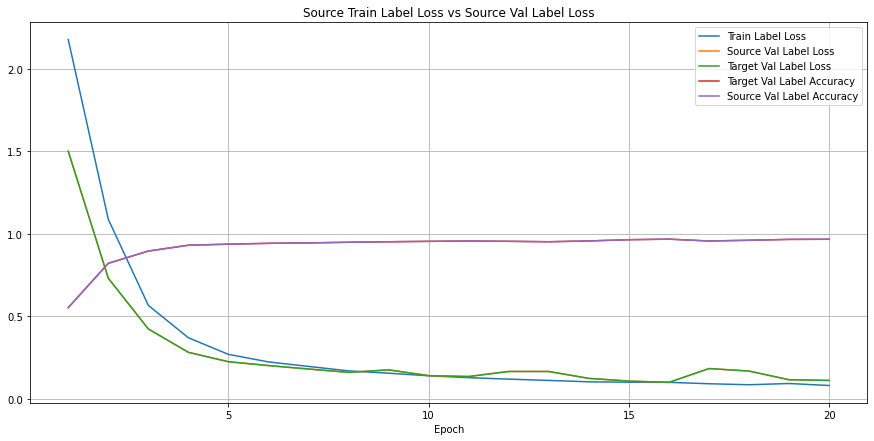

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

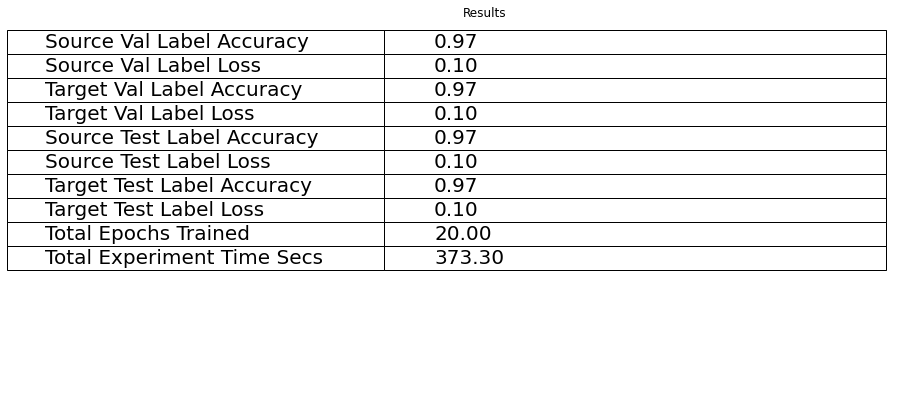

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

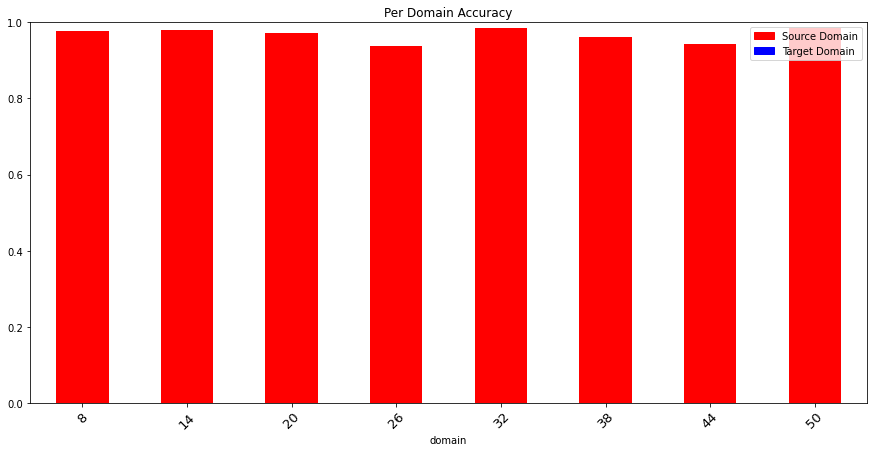

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.96859375 Target Test Label Accuracy: 0.96859375
Source Val Label Accuracy: 0.9680989583333334 Target Val Label Accuracy: 0.9680989583333334


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run2.framed", "parameters": {"experiment_name": "cnn_2:oracle.run2.framed", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": -1, "num_examples_per_domain_per_label_target": -1, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_ch